In [1]:
from numpy.core.fromnumeric import amin
import pandas as pd
from read_input import read_pdbs
import itertools
from itertools import product, combinations


native_pdb, fibril_pdb = read_pdbs()

# Make a dictionary from the pdb of resnum:resid from the pdb structure
pdb_resids = native_pdb.residues.resids.tolist()
amino_dict = dict(zip(pdb_resids,(list(native_pdb.residues.resnames))))

# Same dictionary but also with number and names
pdb_resid_name = native_pdb.residues.resnames + '_' + native_pdb.residues.resids.astype(str)
amino_dict_num = dict(zip(pdb_resids,pdb_resid_name))
#print(amino_dict)
#print(amino_dict_num)

# Create the DataFrame of the pairs list
pairs_list = pd.read_csv('GRETA/output_TTR/pairs_list.txt', sep='\\s+')

pairs_list.insert(1, 'ai_resnumber', '')
pairs_list.insert(1, 'ai_resname', '')
pairs_list.insert(4, 'aj_resnumber', '')
pairs_list.insert(4, 'aj_resname', '')

# Separation of the atomtype and the aminoacid number. 
# The atomtype column will be replaced avoiding to create a column and delete this one.
pairs_list[['ai_resname', 'ai_resnumber']] = pairs_list.ai.str.split("_", expand = True)
pairs_list[['aj_resname', 'aj_resnumber']] = pairs_list.aj.str.split("_", expand = True)
# Replacing the atomtype values with aminoacid number as int
pairs_list['ai_resname'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resname'] = pairs_list['aj_resnumber'].astype(int)
# Conversion from str to int
pairs_list['ai_resnumber'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resnumber'] = pairs_list['aj_resnumber'].astype(int)
# Replacing the aminoacid number with the aminoacid name
pairs_list['ai_resname'] = pairs_list.ai_resname.map(amino_dict)
pairs_list['aj_resname'] = pairs_list.aj_resname.map(amino_dict)

print(pairs_list)#.to_string())


       ai ai_resname  ai_resnumber     aj aj_resname  aj_resnumber  type  \
0    CA_1        TYR             1   CA_1        TYR             1     1   
1    CA_1        TYR             1   CB_1        TYR             1     1   
2    CA_1        TYR             1  CB_11        SER            11     1   
3    CA_1        TYR             1   CB_2        THR             2     1   
4    CA_1        TYR             1  CD1_1        TYR             1     1   
..    ...        ...           ...    ...        ...           ...   ...   
901   O_7        LEU             7    O_7        LEU             7     1   
902   O_7        LEU             7    O_8        SER             8     1   
903   O_8        SER             8    O_8        SER             8     1   
904   O_8        SER             8    O_9        PRO             9     1   
905   O_9        PRO             9    O_9        PRO             9     1   

           c6           c12     sigma  epsilon  
0    0.007580  3.934877e-05  0.416116 

In [2]:
contacts_histogram = {}
for an in pdb_resids:
    # pdb_resids is the aminocid numbers
    # Selection of the rows contaning the aminoacid number of interest.
    # Note the | and not the &
    is_an = (pairs_list['ai_resnumber'] == an) | (pairs_list['aj_resnumber'] == an)

    # Filtering a dataframe containing only the aminoacid selected.
    pairs_an = pairs_list[is_an]

    print(f'Total amount of contacts made by {amino_dict_num.get(an)}:', len(pairs_an))
    #print(pairs_an)
    pairs_an.loc[pairs_an['ai_resnumber'] == an, 'an_with_who'] = pairs_an['aj_resname'] + '_' + pairs_an['aj_resnumber'].astype(str)
    pairs_an.loc[pairs_an['ai_resnumber'] != an, 'an_with_who'] = pairs_an['ai_resname'] + '_' + pairs_an['ai_resnumber'].astype(str)

    #print(pairs_an)
    an_with_who = pairs_an.an_with_who.value_counts()
    contacts_histogram['{0}'.format(an)] = an_with_who.to_dict()
    print(an_with_who.to_string())

#print(contacts_histogram)

Total amount of contacts made by TYR_1: 189
TYR_1     68
SER_11    54
TYR_10    35
THR_2     29
ILE_3      3
Total amount of contacts made by THR_2: 128
TYR_1     29
ILE_3     28
THR_2     26
TYR_10    20
SER_11    12
PRO_9     10
ALA_4      3
Total amount of contacts made by ILE_3: 126
ILE_3     32
THR_2     28
ALA_4     24
TYR_10    15
SER_8     12
PRO_9      9
ALA_5      3
TYR_1      3
Total amount of contacts made by ALA_4: 78
ILE_3    24
ALA_4    15
ALA_5    14
LEU_7    11
PRO_9     9
THR_2     3
LEU_6     2
Total amount of contacts made by ALA_5: 67
LEU_6    25
ALA_5    14
ALA_4    14
LEU_7    11
ILE_3     3
Total amount of contacts made by LEU_6: 112
LEU_7     42
LEU_6     35
ALA_5     25
SER_8      5
SER_11     3
ALA_4      2
Total amount of contacts made by LEU_7: 131
LEU_6     42
LEU_7     34
SER_8     22
ALA_5     11
ALA_4     11
PRO_9      9
SER_11     2
Total amount of contacts made by SER_8: 132
PRO_9     29
SER_11    25
LEU_7     22
SER_8     20
TYR_10    19
ILE_3     12

In [3]:
# Dataframe preparation

histo_df = pd.DataFrame(contacts_histogram)
histo_df[''] = histo_df.index.astype(str)
histo_df[''] = histo_df[''].str.split('_').str[1].astype(int)
histo_df.sort_values(by = [''], inplace = True)
histo_df.drop(columns='', inplace=True)
histo_df = histo_df.fillna(0)
histo_df.columns = list(amino_dict_num.values())
print(histo_df.to_string())



        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    68.0   29.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0    35.0    54.0
THR_2    29.0   26.0   28.0    3.0    0.0    0.0    0.0    0.0   10.0    20.0    12.0
ILE_3     3.0   28.0   32.0   24.0    3.0    0.0    0.0   12.0    9.0    15.0     0.0
ALA_4     0.0    3.0   24.0   15.0   14.0    2.0   11.0    0.0    9.0     0.0     0.0
ALA_5     0.0    0.0    3.0   14.0   14.0   25.0   11.0    0.0    0.0     0.0     0.0
LEU_6     0.0    0.0    0.0    2.0   25.0   35.0   42.0    5.0    0.0     0.0     3.0
LEU_7     0.0    0.0    0.0   11.0   11.0   42.0   34.0   22.0    9.0     0.0     2.0
SER_8     0.0    0.0   12.0    0.0    0.0    5.0   22.0   20.0   29.0    19.0    25.0
PRO_9     0.0   10.0    9.0    9.0    0.0    0.0    9.0   29.0   26.0    33.0     7.0
TYR_10   35.0   20.0   15.0    0.0    0.0    0.0    0.0   19.0   33.0    62.0    25.0
SER_11   54.0   12.0    0.0    0.0    0.0    3.0    2.

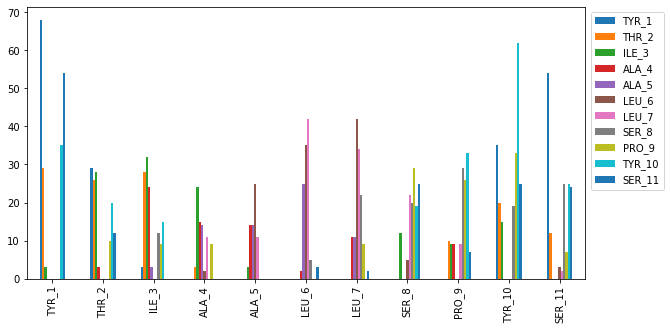

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_df.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.show()

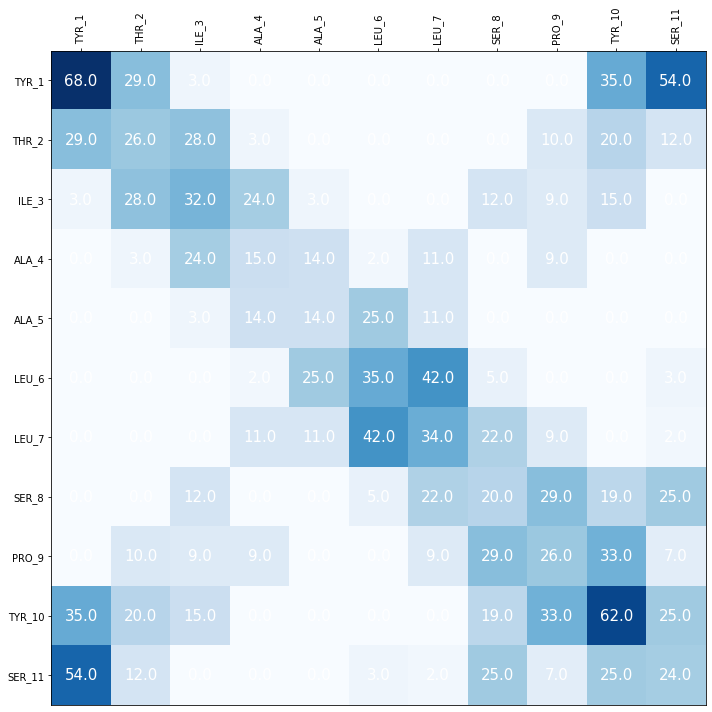

In [5]:
import numpy as np

matrix_df = histo_df.to_numpy()
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df.columns)))
ax.set_yticks(np.arange(len(histo_df.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df.columns))
ax.set_yticklabels(list(histo_df.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df.index)):
    for j in range(len(histo_df.columns)):
        text = ax.text(j,i, matrix_df[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.tight_layout()